##audio processing learning notebook

In [ ]:
# install the stuff colab doesn't have
!pip install vosk
!pip install noisereduce
!sudo apt update && sudo apt install ffmpeg

import rest of our dependencies

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import noisereduce as nr
import soundfile as sf
import os
from vosk import Model, KaldiRecognizer
import wave
import json
from IPython.display import Audio

download vosk model

In [ ]:
def download_vosk_model(model_name='vosk-model-en-us-0.22-lgraph', model_url='http://alphacephei.com/vosk/models'):
    if not os.path.exists(model_name):
        print(f"Downloading '{model_name}'")
        !wget {model_url}/{model_name}.zip
        !unzip {model_name}.zip
        !rm {model_name}.zip

download_vosk_model()

upload files bc google breaks compat with firefox zzzz

In [ ]:
from google.colab import files
files.upload()

# the output of this is absolutely disgusting. it spit out the entire file byte by byte.
# removed output to save your eyes
# google pls fix colab uploading in firefox so i don't need this code block

load up the audio file we want to work with.

In [6]:
# load audio file
audio_path = 'harvard.wav'
audiofile, sr = librosa.load(audio_path, sr=None)
Audio(audio_path)

display original waveform for file

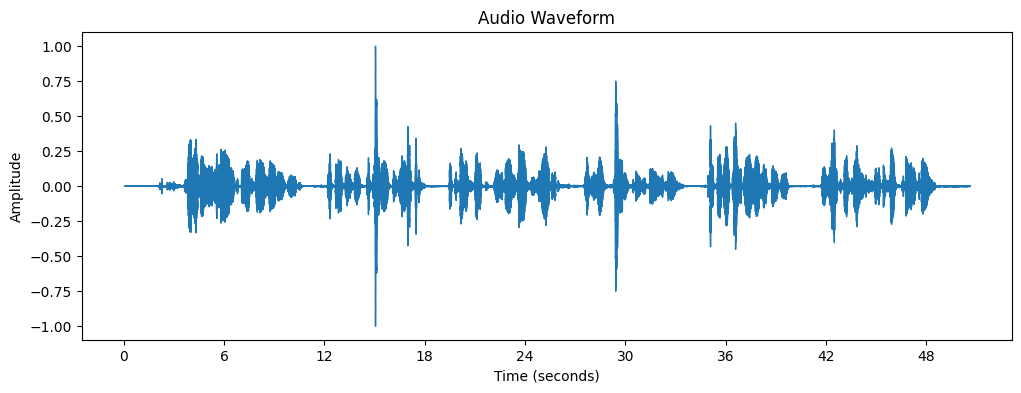

In [36]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audiofile, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

noise removal and visualization

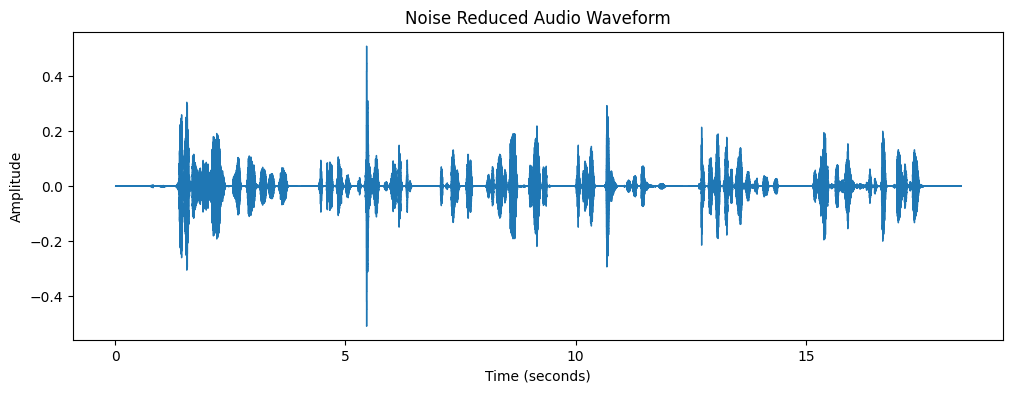

In [22]:
noise_reduced_audio = nr.reduce_noise(y=audiofile, sr=sr)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(noise_reduced_audio, sr=sr)
plt.title('Noise Reduced Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

return our noise reduced file for comparison

In [8]:
output_file = 'processed_audio.wav'
sf.write(output_file, noise_reduced_audio, sr)
Audio(output_file)

visualize both overlaid

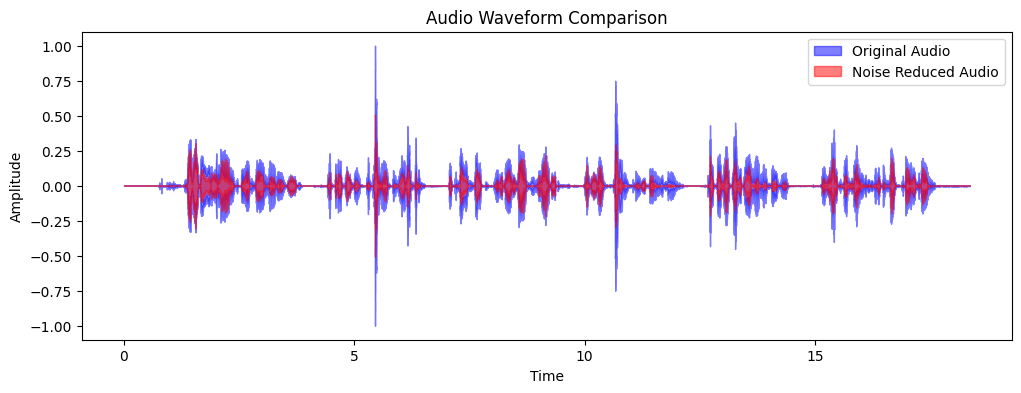

In [24]:
plt.figure(figsize=(12, 4))

# old waveform in blue
librosa.display.waveshow(audiofile, sr=sr, color='blue', alpha=0.5, label='Original Audio')
plt.title('Audio Waveform Comparison')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# new waveform in red
librosa.display.waveshow(noise_reduced_audio, sr=sr, color='red', alpha=0.5, label='Noise Reduced Audio')

plt.legend()

plt.show()

transcribe our file

In [26]:
def transcribe(audio_file, model_name='vosk-model-en-us-0.22-lgraph'):
    # check if model exists
    if not os.path.exists(model_name):
        raise FileNotFoundError(f"Model not found: {model_name}")
    try:
        model = Model(model_name)
    except Exception as e:
        raise RuntimeError(f"Failed to load model: {e}")
    try:
        with wave.open(audio_file, "rb") as wf:
            rec = KaldiRecognizer(model, wf.getframerate())
            text = ''
            while True:
                data = wf.readframes(4000)
                if not data:
                    break
                if rec.AcceptWaveform(data):
                    result = json.loads(rec.Result())
                    if 'text' in result:
                        text += result['text'] + ' '

            final_result = json.loads(rec.FinalResult())
            if 'text' in final_result:
                text += final_result['text']
            return text.strip()
    except Exception as e:
        raise RuntimeError(f"Failed to process file: {e}")

original_transcription = transcribe(audio_path)
filtered_transcription = transcribe(output_file)

print(original_transcription)
print("\n\n")
print(filtered_transcription)

# why is the original transcription is so borked???

the stylish the harsh at trump on the the have bap wash wash her past shirt pattern cash from with him caught the or post turtle firefly this porsche



the stale smell of old bear lingers it takes heat to bring out the odor a cold dip restores help zest a salt people tastes fine with me tacos al pastor are my favorite a zestful food is the hot cross bun


chunk the file

In [35]:
def get_audio_chunks(audio_file, chunk_size=1.0, sr=16000):
    audio_data, _ = librosa.load(audio_file, sr=sr)
    int_audio = (audio_data * 32767).astype('int16')

    chunks = []
    chunk_samples = int(chunk_size * sr)

    for start in np.arange(0, len(int_audio), chunk_samples):
        end = min(start + chunk_samples, len(int_audio))
        chunks.append(int_audio[start:end])
    return chunks

sr = 16000
audio_chunks_old = get_audio_chunks(audio_path, chunk_size=3.0, sr=sr)
audio_chunks_new = get_audio_chunks(output_file, chunk_size=3.0, sr=sr)

visualize chunks

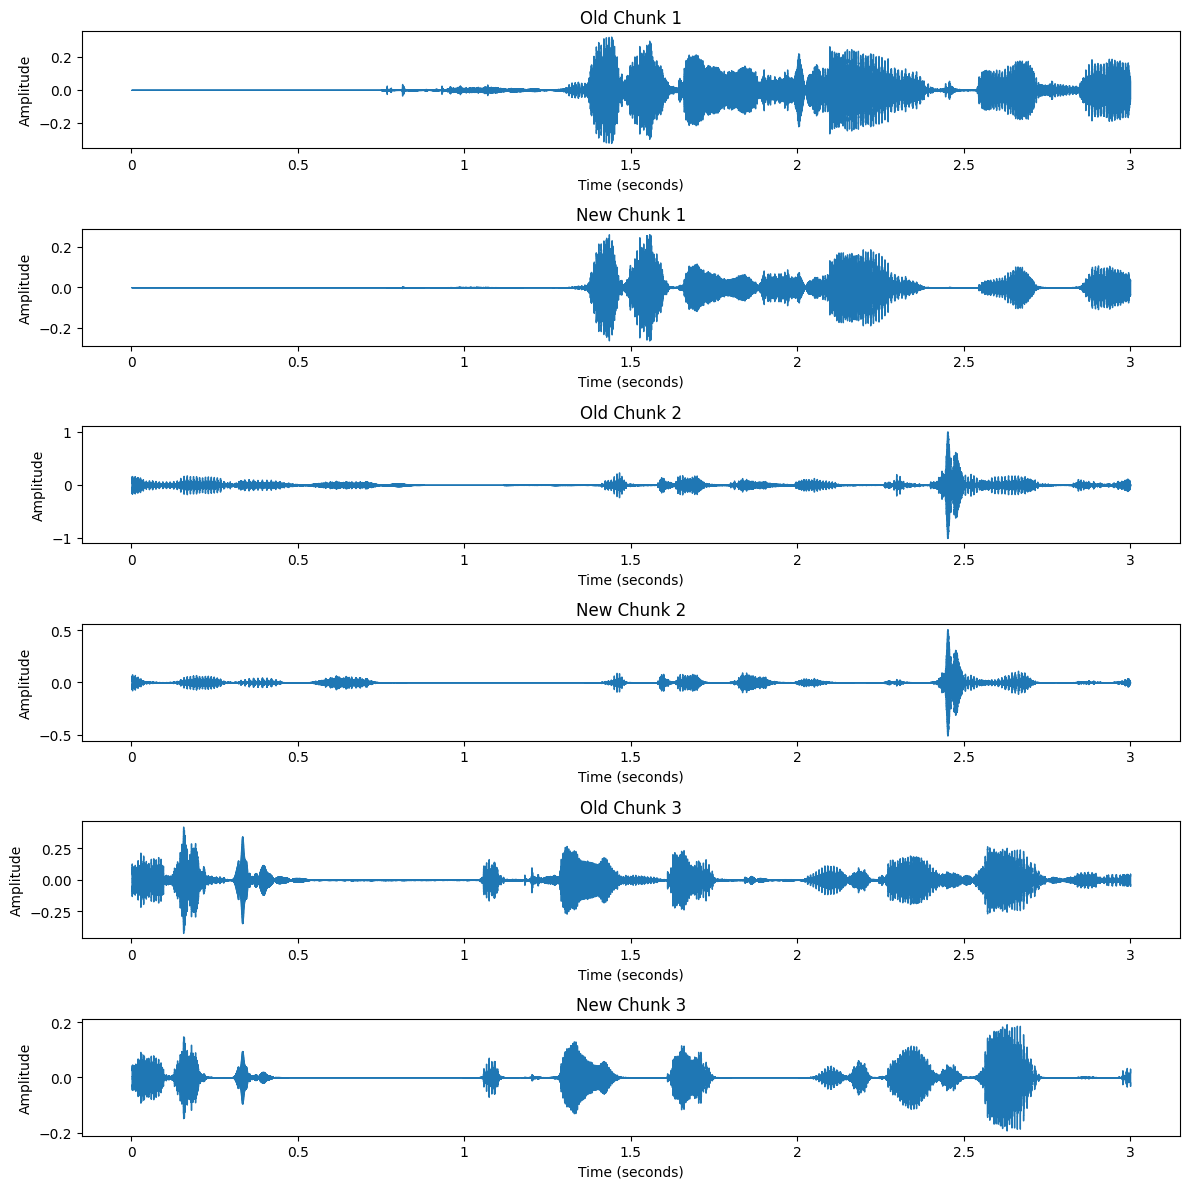

In [34]:
def chunk_visualizer(audio_chunks_old, audio_chunks_new):
    num_pairs_to_display = 3 # adjust as needed, only using 3 for the sake of space
    num_chunks_to_display = 2 * num_pairs_to_display
    fig, axs = plt.subplots(min(num_chunks_to_display, len(audio_chunks_old) + len(audio_chunks_new)), 1, figsize=(12, 2 * min(num_chunks_to_display, len(audio_chunks_old) + len(audio_chunks_new))))

    # make sure in the case that we only have a single chunk we still throw it into a list
    if len(audio_chunks_old) + len(audio_chunks_new) == 1 or num_chunks_to_display == 1:
        axs = [axs]

    for i in range(num_pairs_to_display):
        if i < len(audio_chunks_old):
            # old chunk
            float_chunk_old = audio_chunks_old[i].astype('float32') / 32767
            librosa.display.waveshow(float_chunk_old, sr=sr, ax=axs[2*i])
            axs[2*i].set_title(f'Old Chunk {i+1}')
            axs[2*i].set_xlabel('Time (seconds)')
            axs[2*i].set_ylabel('Amplitude')
        if i < len(audio_chunks_new):
            # new chunk
            float_chunk_new = audio_chunks_new[i].astype('float32') / 32767
            librosa.display.waveshow(float_chunk_new, sr=sr, ax=axs[2*i + 1])
            axs[2*i + 1].set_title(f'New Chunk {i+1}')
            axs[2*i + 1].set_xlabel('Time (seconds)')
            axs[2*i + 1].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

chunk_visualizer(audio_chunks_old, audio_chunks_new)